# Asian Option Pricing

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Initial setup, values of variables
S0 = 100
K = S0
r = .02
sigma = .18
T = 1/2          #maturity: 6 months
n_simul = 10**4  #number of simulation (10000)
days = 264       #annual business days


In [3]:
def gbm_simulate(mu: float, sigma: float, initial: float,
                 n_paths: int, time_step: float, n_periods: int,
                 rng: np.random._generator.Generator):
    """
    Simulate paths for a Geometric Brownian motion.
    Note that this function has a side effect because it changes the state of the random number generator.
    """
    
    logS = np.empty((n_periods + 1, n_paths))  # Pre-allocation with an empty array
    
    logS[0, :] = np.log(initial)  # Initial log price
    
    m = mu - .5 * sigma**2  # Expected log return
    
    for i in range(1, n_periods + 1):
        std_innov = rng.standard_normal(n_paths)
        logS[i, :] = logS[i - 1, :] + m * time_step + sigma * np.sqrt(time_step) * std_innov
        
    S = np.exp(logS)    
    
    return S

Using the function to simulate 10000 scenarios:

In [4]:
rng = np.random.default_rng(seed=123)

S = gbm_simulate(r, sigma, S0, n_simul, 1/264, 132, rng)

Then visualize it:

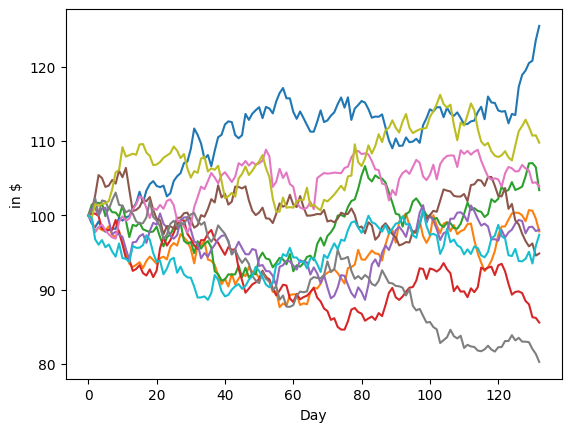

In [5]:
plt.plot(S[:, 0: 10])
plt.xlabel('Day')
plt.ylabel('in $')
plt.show()

This function takes in data of stock price ('S') and value of strike ('K') and return the payoff

In [6]:
def A_option_payoff(S,K):

    payoff = np.mean(S, axis = 0)-K
    
    # Keep payoff if it is positive
    payoff = np.maximum(payoff, 0)
    
    return payoff

This function receives payoff data and interest rate and maturity as inputs, and returns the Asian option price by the given formula:
$$
C_{0} = e^{-rT}E[C_{t}]
$$

In [7]:
def A_option_price(payoff,r,T):
    return np.exp(-r*T) * np.mean(payoff)

Using these two `A_option_payoff` and `A_option_price` function with simulated stock price S and given strike K to calculate Asian option price

In [8]:
payoff_daily = A_option_payoff(S, K)
print('option payoﬀ using daily monitoring dates is\n', payoff_daily)

option payoﬀ using daily monitoring dates is
 [10.75836063  0.          0.         ... 10.08357208  0.
  0.        ]


In [9]:
C0_daily = A_option_price(payoff_daily,r,T)
print('option price using daily monitoring dates is', C0_daily)

option price using daily monitoring dates is 3.1672768183719486


In this step we use the same idea as before to simulate S and visualize it, but replace time step from 1/132 (daily monitoring) to 1/27 (weekly monitoring)

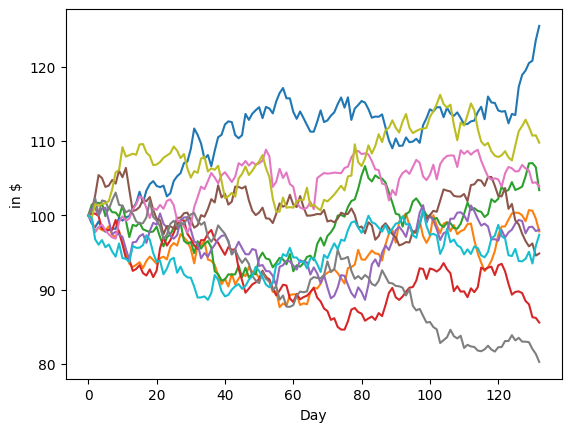

In [10]:
S_weekly = gbm_simulate(r, sigma, S0, n_simul, 1/27, 27, rng)

plt.plot(S[:, 0: 10])
plt.xlabel('Day')
plt.ylabel('in $')
plt.show()

In [11]:
payoff_wk = A_option_payoff(S_weekly, K)
print('option payoﬀ using weekly monitoring dates is\n', payoff_wk)

option payoﬀ using weekly monitoring dates is
 [1.84020505 0.         0.         ... 0.         9.32240953 0.        ]


In [12]:
C0_wk = A_option_price(payoff_wk,r,T)
print('option price using weekly monitoring dates is', C0_wk)

option price using weekly monitoring dates is 4.66837234599758


## With Confidence Interval

this function returns payoffs with daily maturities from 2 inputs: stock prices and strike

In [13]:
def A_option_payoff_daily(S, K):
    
    # Create a blank 2D array for payoff to store values
    payoff = np.zeros((len(S),len(S[0])))
    
    # Loop through each element of payoff's row, i.e each day
    for i in range (1,len(payoff)):
        # Loop through each element of payoff's column, i.e each scenario
        for j in range (len(payoff[i])):
            # Calculate average price of S until day i in the scenario j
            av_price = np.mean(S[:i,j])
            # Replace element of day i of scenario j of 'payoff' by average price minus strike
            payoff[i][j] = av_price-K
            # Replace negative value of payoff by 0
            payoff[i][j] = np.maximum(payoff[i][j],0)
    
    return payoff

This function calculate the confidence interval by the formula:
$$
Confidence interval (95\%) = \frac{1.96*σ_{payoff}*discount factor}{√simulation}
$$

Then the upper and lower bounds are calculated by:
$$
Upper bound = Option price + Confidence interval
$$
$$
Lower bound = Option price - Confidence interval
$$

In [14]:
def A_confidence_bounds(payoff,C0,discount_factor,n_simul,r):
    
    confidence_interval = 1.96 * np.std(payoff,axis=1) * discount_factor / np.sqrt(n_simul)
    upper_bound, lower_bound = C0 + confidence_interval, C0 - confidence_interval
    
    return upper_bound, lower_bound

In [15]:
def A_option_price_daily(S,K,n_simul,r,days):
    
    payoff = A_option_payoff_daily(S, K)

    # Blank array for variable 'discount_factor' to store value
    discount_factor = np.ones((payoff.shape[0]))
    
    for i in range (1,discount_factor.shape[0]):
        #at date i (i.e the i-th element of discount_factor), replace this element by e^-r*i/number of days in a year
        discount_factor[i] = np.exp(-r*i/days)
    
    C0 = discount_factor * np.mean(payoff, axis = 1)
    
    #Calculate upper bound and lower bound
    upper_bound, lower_bound = A_confidence_bounds(payoff,C0,discount_factor,n_simul,r)
    
    return C0, upper_bound, lower_bound

Now let's call the functions:

In [16]:
result = A_option_price_daily(S,K,n_simul,r,days)
C0_CI = result[0]
upper_bound, lower_bound = result[1], result[2]

Visualize option price (green line), upper bound (red dash line) and lower bound (blue dash line) using Matplotlib, with x-axis showing the maturities (day 1 to day 132) and y-axis showing option prices for each maturity.

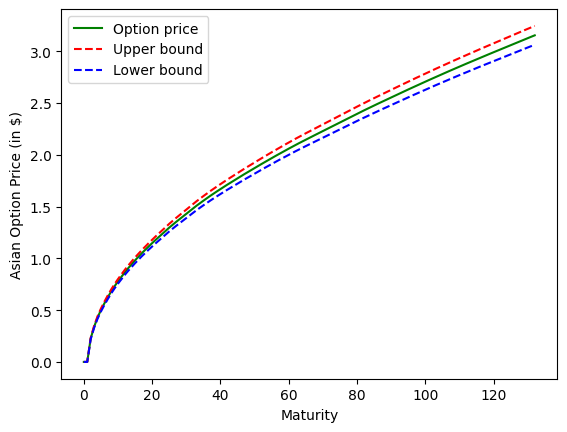

In [17]:
date = np.arange(0,133,1)
plt.plot(date,C0_CI, '-g', label = 'Option price')
plt.plot(date,upper_bound, linestyle='dashed', color ='r', label = 'Upper bound')
plt.plot(date,lower_bound, linestyle='dashed', color ='b', label = 'Lower bound')
plt.xlabel("Maturity")
plt.ylabel("Asian Option Price (in $)")
plt.legend()
plt.show()